In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import History

# Transfer learning

<br>

<img src="Grafika/transfer_learning.png" width="550">

**Transfer learning** (transfer "wiedzy") - wykorzystanie nauczonych przez kogoś sieci do naszego problemu. Możliwe dzięki temu, że cechy wykrywane przez sieci w głębokich warstwach mogą być uniwersalne i przydatne w różnych problemach.

### VGG16

In [3]:
from keras.applications import VGG16, InceptionV3
base_model = VGG16(weights='imagenet',include_top=False)
base_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____________________________________________

### InceptionV3

In [4]:
inc = InceptionV3()
inc.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________

# Zad
Trzeba nadać wymiar wejści anaszej sieci
```python
h,w = 32, 32
```

In [5]:
h,w = 32, 32
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

In [6]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [7]:
len(model.layers)

19

# Zad 
Zbudujmy siec z 
* VGG16 dla wejścia h,w = 32, 32
* Flatten
* Dense
* Dense

In [8]:
h,w = 32, 32
model = VGG16(weights='imagenet',include_top=False,input_shape=(h,w,3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(4, activation='sigmoid'))

model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(top_model)

model_transfer.layers[0].trainable = False

model_transfer.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential_1 (Sequential)    (None, 4)                 132356    
Total params: 14,847,044
Trainable params: 132,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
# model.summary()
# top_model.summary()

In [10]:
from keras.datasets import cifar10
from keras.utils import np_utils
# from scipy.misc import toimage

import numpy as np

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

nb_classes = 4
n_samples = 7000

X_train, y_train = X_train[np.where(y_train<nb_classes)[0]][:n_samples], y_train[np.where(y_train<nb_classes)[0]][:n_samples]
X_test, y_test = X_test[np.where(y_test<nb_classes)[0]], y_test[np.where(y_test<nb_classes)[0]]

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train,return_counts=True))
print(X_train[0].shape)

# normalize inputs from 0-255 to 0.0-1.0

# X_train = X_train/255
# X_test = X_test/255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

X_train[0].shape

(7000, 32, 32, 3)
(4000, 32, 32, 3)
(array([0, 1, 2, 3], dtype=uint8), array([1738, 1733, 1779, 1750], dtype=int64))
(32, 32, 3)


(32, 32, 3)

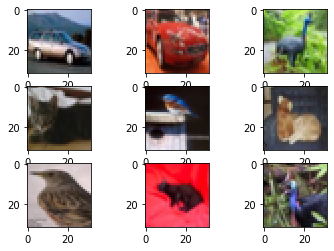

In [11]:
# create a grid of 3x3 images
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

In [12]:
from keras.preprocessing.image import ImageDataGenerator


batch_size = 32
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

validation_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

# model_transfer.fit_generator(train_generator, epochs=50, validation_data=validation_generator)

In [13]:
batch_size

32

In [14]:
len(X_train)

7000

In [15]:
7000//32

218

In [19]:
# model.evaluate(X_test,y_test)
history_tr = History()
early_stopping = EarlyStopping(patience=30,monitor="val_loss")
model_transfer.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])



model_transfer.fit_generator(train_generator, samples_per_epoch=len(X_train), epochs=100, 
                    validation_data=validation_generator, nb_val_samples=batch_size,callbacks =[early_stopping, history_tr])
model_transfer.evaluate(X_test/255,y_test)

# X_test = X_test/255
# 
# model_transfer.fit_generator(train_generator, samples_per_epoch=len(X_train), epochs=100, 
#                     validation_data= (X_test, y_test),callbacks =[early_stopping, history_tr])
# model_transfer.evaluate(X_test,y_test)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=100, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=218, validation_steps=32)`
  if __name__ == '__main__':


Epoch 1/100
218/218 [==============================] - 29s 132ms/step - loss: 0.5492 - accuracy: 0.7889 - val_loss: 0.6041 - val_accuracy: 0.7500
Epoch 2/100
218/218 [==============================] - 31s 140ms/step - loss: 0.5348 - accuracy: 0.7920 - val_loss: 0.6304 - val_accuracy: 0.7705
Epoch 3/100
218/218 [==============================] - 30s 136ms/step - loss: 0.5259 - accuracy: 0.7966 - val_loss: 0.5733 - val_accuracy: 0.7617
Epoch 4/100
218/218 [==============================] - 30s 136ms/step - loss: 0.5098 - accuracy: 0.8032 - val_loss: 0.6232 - val_accuracy: 0.7676
Epoch 5/100
218/218 [==============================] - 36s 167ms/step - loss: 0.5144 - accuracy: 0.7955 - val_loss: 0.5563 - val_accuracy: 0.7432
Epoch 6/100
218/218 [==============================] - 37s 171ms/step - loss: 0.5146 - accuracy: 0.7955 - val_loss: 0.6294 - val_accuracy: 0.7881
Epoch 7/100
218/218 [==============================] - 37s 172ms/step - loss: 0.5019 - accuracy: 0.8057 - val_loss: 0.6621 -

[0.7086856462955475, 0.7522500157356262]

In [22]:
model_transfer.evaluate(X_test/255,y_test)

4000/4000 [==============================] - 13s 3ms/step


[0.7086856462955475, 0.7522500157356262]

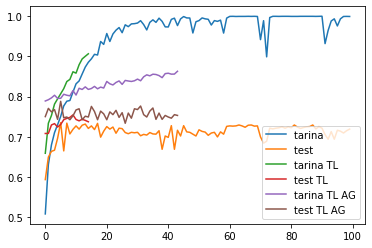

In [23]:
history_11 = np.loadtxt("cifar_10_part_conv_tr.txt")
history_12 = np.loadtxt("cifar_10_part_conv_te.txt")

history_tr_11 = np.loadtxt("cifar_10_part_conv_Tr_Le_tr.txt")
history_tr_12 = np.loadtxt("cifar_10_part_conv_Tr_Le_te.txt")

plt.plot(history_11, label = "tarina ")
plt.plot(history_12, label = "test ")

plt.plot(history_tr_11, label = "tarina TL")
plt.plot(history_tr_12, label = "test TL")

plt.plot(history_tr.history['accuracy'], label = "tarina TL AG")
plt.plot(history_tr.history['val_accuracy'], label = "test TL AG")


plt.legend()
plt.show()